#### **1. Hiểu và nhận xét tổng quan về dữ liệu**
##### **Bước 1: check null, số lượng mẫu và phân bố nhãn**
- Dữ liệu không thiếu gì và phân bố nhãn là uniform distribution 

In [20]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from scipy.stats import zscore, norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
df = pd.read_csv("6. Weather.csv")
print(df.isnull().sum())
print(df['Weather Type'].value_counts())

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64
Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64


##### **Bước 2: phân tích đặc điểm của từng feature.**
- Với dữ liệu numerical, ta sẽ tiến hành vẽ histogram để nhìn phân bố và nhìn các chỉ số thống kê như là: mean, median, min, max, phương sai. 
- Với dữ liệu numerical, ta sẽ tiến hành xét phân phối các giá trị. 

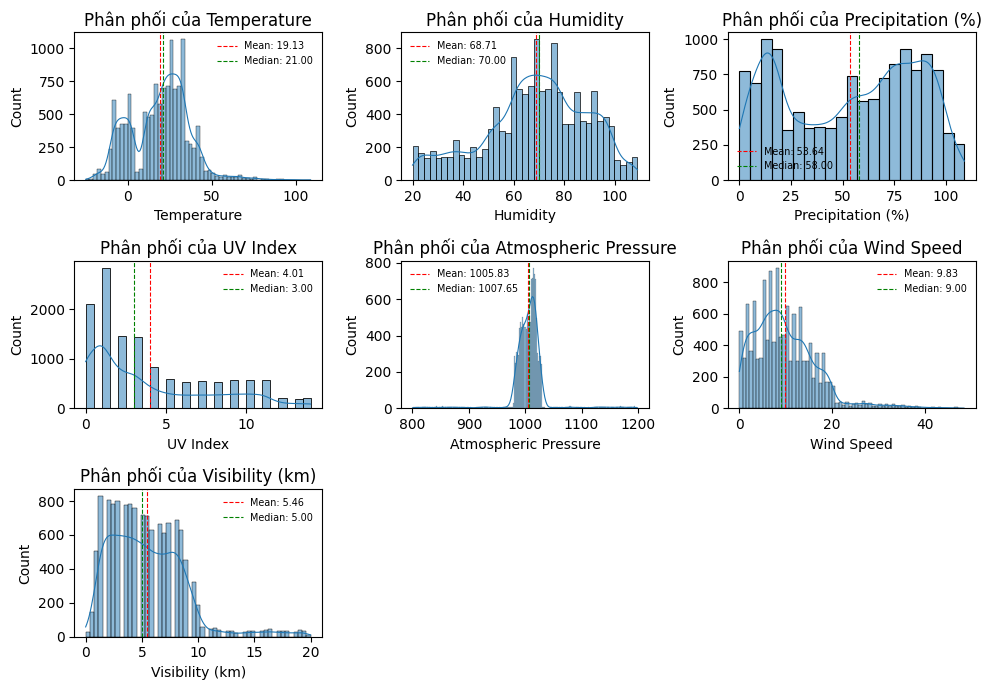

In [21]:
numerical_cols = ['Temperature','Humidity','Precipitation (%)','UV Index','Atmospheric Pressure','Wind Speed','Visibility (km)']
categorical_cols = ['Cloud Cover','Season','Location']
stats = df[numerical_cols].describe()
stats.loc['variance'] = df[numerical_cols].var()
plt.figure(figsize=(10, 7)) 
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, line_kws={'linewidth': 0.8})
    plt.title(f'Phân phối của {col}', pad=5)
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=0.8, label=f'Mean: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=0.8, label=f'Median: {df[col].median():.2f}')
    plt.legend(fontsize='x-small', loc='best', frameon=False)
    plt.tight_layout(pad=1.0) 

plt.tight_layout()
plt.show()

Từ các biểu đồ của numerical features phía trên và tri thức miền, ta có một số nhận xét như sau:
- Có rất nhiều mẫu thu bị lỗi, cụ thể như sau:
    - Biến `temperature`: theo các bài báo trên mạng thì nhiệt độ cao nhất trên thế giới là [93,9°C](https://en.wikipedia.org/wiki/Highest_temperature_recorded_on_Earth) nên nhìn vào biểu đồ ta thấy có một số giá trị quá 100°C chắc chắn là do thu kết quả sai
    - Các biến `humidity` và `precipitation`: có số lượng mẫu thu kết quả sai đáng kể khi đơn vị là % mà có nhiều giá trị >= 100.
- Mean, median các features khá gần nhau.
- Ngoài một số biến có đơn vị là % như: `humidity`, `precipitation` có outlier là các mẫu thu sai có đơn vị quá khoảng [0,100] thì khi nhìn histogram, những thuộc tính còn lại không có outlier ngoài khoảng miền giá trị có thể của thuộc tính đó dựa vào thông tin tra mạng. 

Biểu đồ của các categorical features phía dưới không có gì quá đặc biệt. 

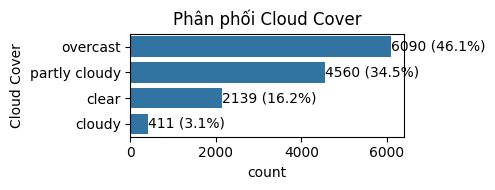

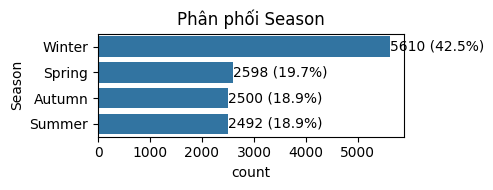

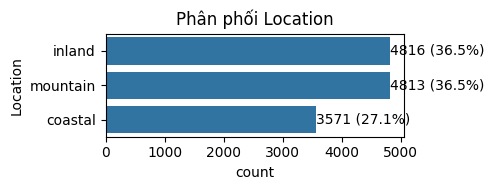

In [22]:
for col in categorical_cols:
    vc = df[col].value_counts()
    pct = vc / vc.sum() * 100
    plt.figure(figsize=(5, 2))
    ax = sns.countplot(y=col, data=df, order=vc.index)
    plt.title(f'Phân phối {col}')
    for i, v in enumerate(vc): ax.text(v + 0.5, i, f"{v} ({pct.iloc[i]:.1f}%)", va='center')
    plt.tight_layout(); plt.show()

##### **Bước 3: Xét mối quan hệ giữa các feature.** 
Em vẽ heatmap để vẽ correlation giữa các numerical feature với nhau. Đối với các numerical feature với nhau, em đã vẽ thử và không rút ra được kết luận gì nên sẽ không trình bày. Đối với các numerical feature với categorical feature, em thấy cũng không có gì để trình bày. 

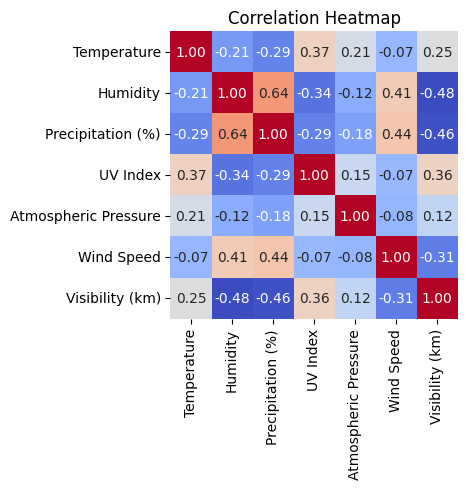

In [23]:
corr = df[numerical_cols].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


Dễ thấy các biến cũng không tương quan quá mạnh với nhau, chỉ có `Precipitation` và `Humidity` có giá trị tương quan tuyệt đối >= 0.5. Điều này cũng dễ hiểu từ khái niệm thực tế của 2 feature này. Em vẽ thêm thử đồ thị giữa 2 biến này để quan sát thì hai biến cũng gần như có mối quan hệ tuyến tính với nhau. 

<Axes: xlabel='Humidity', ylabel='Precipitation (%)'>

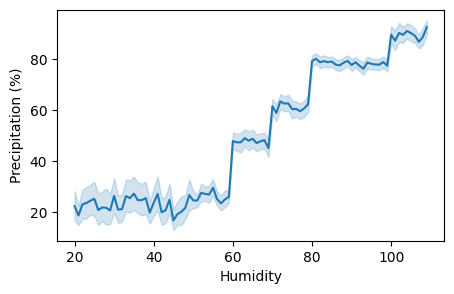

In [24]:
plt.figure(figsize = (5, 3))
sns.lineplot(data = df, x = 'Humidity', y = 'Precipitation (%)')

#### **2. Xét mối quan hệ giữa các features với biến Weather Type**

Do biến target có dạng categorical nên em sẽ vẽ box plot để thể hiện mối quan hệ giữa feature numerical với target, stacked bar plot thể hiện mối quan hệ giữa feature categorical với target

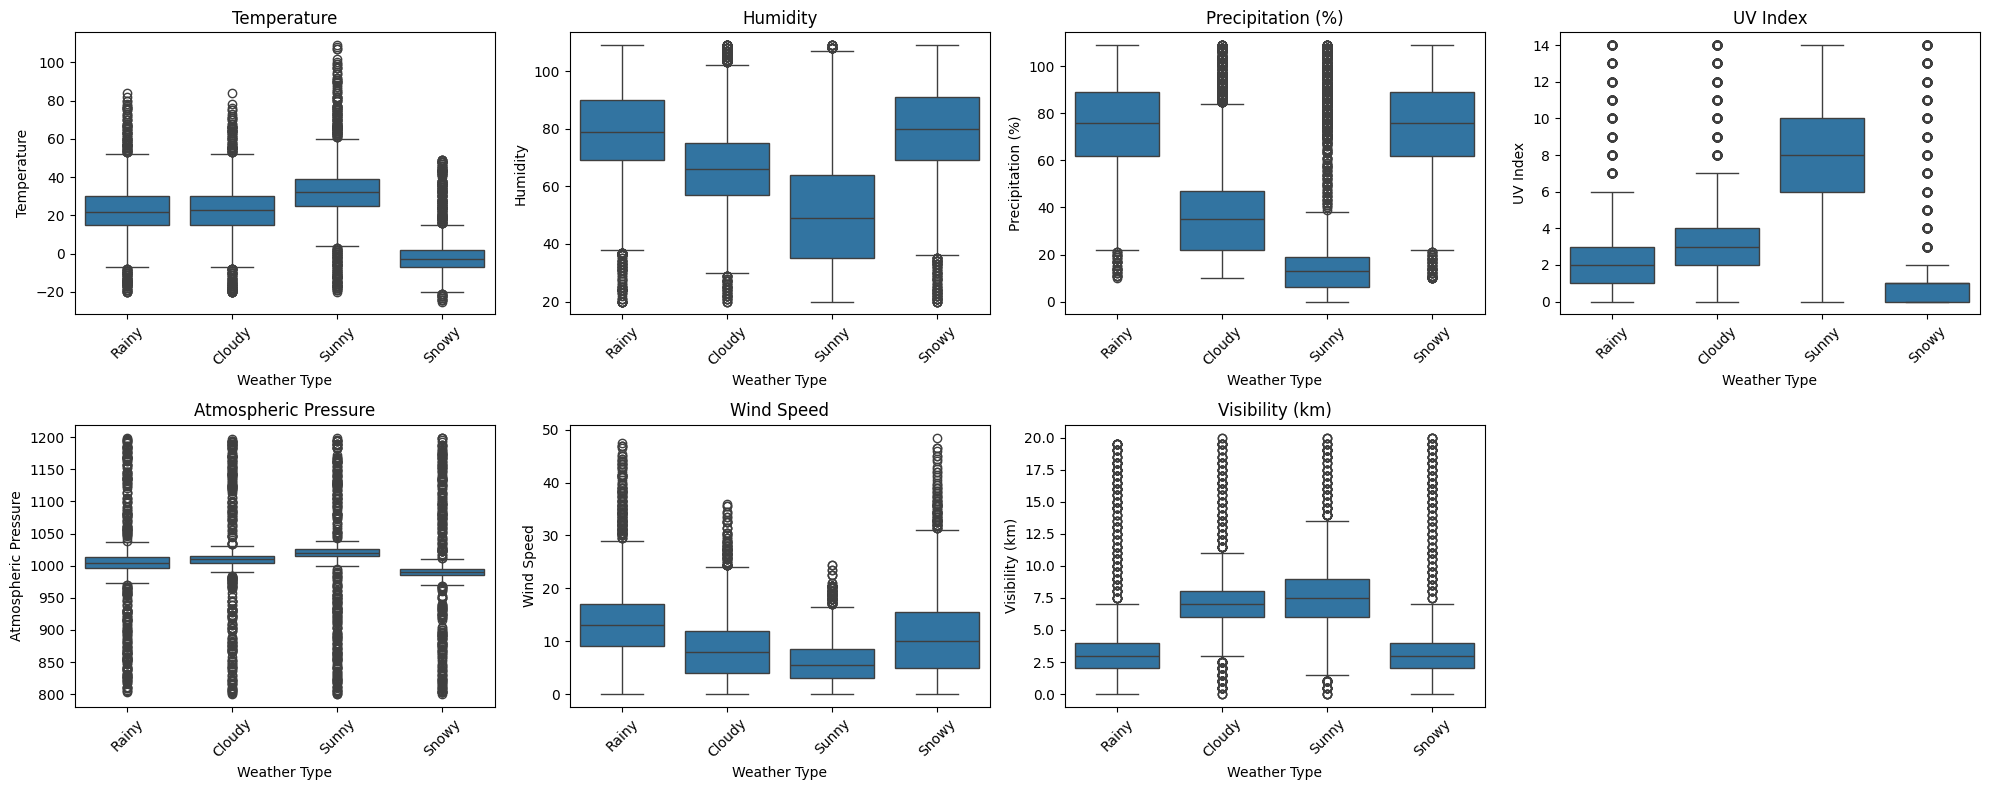

In [25]:
plt.figure(figsize=(20, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=df, x='Weather Type', y=col)
    plt.xticks(rotation=45)
    plt.title(col)
plt.tight_layout()
plt.show()

Phân tích quan hệ từng numerical feature với biến `Weather Type`:
- Biến `Temperature`: là feature phân biệt mạnh giữa `Snowy` và các class khác.
- Biến `Humidity` và `Precipitation`: có tương quan rất cao, thường tỷ lệ thuận với nhau trong các lớp `Weather Type` và có thể dùng cùng nhau để phân biệt tốt `Sunny` với `Rainy/Snowy`
- Biến `Wind speed`: `Rainy` và `Snowy` có gió mạnh hơn trong khi `Sunny` có gió nhẹ nhất. Có nhiều outlier trong dữ liệu gió
- Biến `Atmospheric Pressure`: có chênh lệch nhẹ hơn trong các lớp `Weather Type` nhưng thường khi `Sunny/Cloudy` - lúc trời quang đãng thường áp suất cao hơn `Rainy/Snowy` do theo tri thức miền là có áp suất không khí thấp hơn do đối lưu lúc mưa. 
- Biến `UV Index` và `Visibility` là chỉ báo rất đặc trưng cho Sunny (giá trị lớn và range rộng).
    - Dễ thấy với `Weather Type` == `Snowy`thì đặc trưng là có median UV Index <= 2 
    - Dễ thấy với `Weather Type` == `Sunny`thì đặc trưng là có median UV Index >= 6 

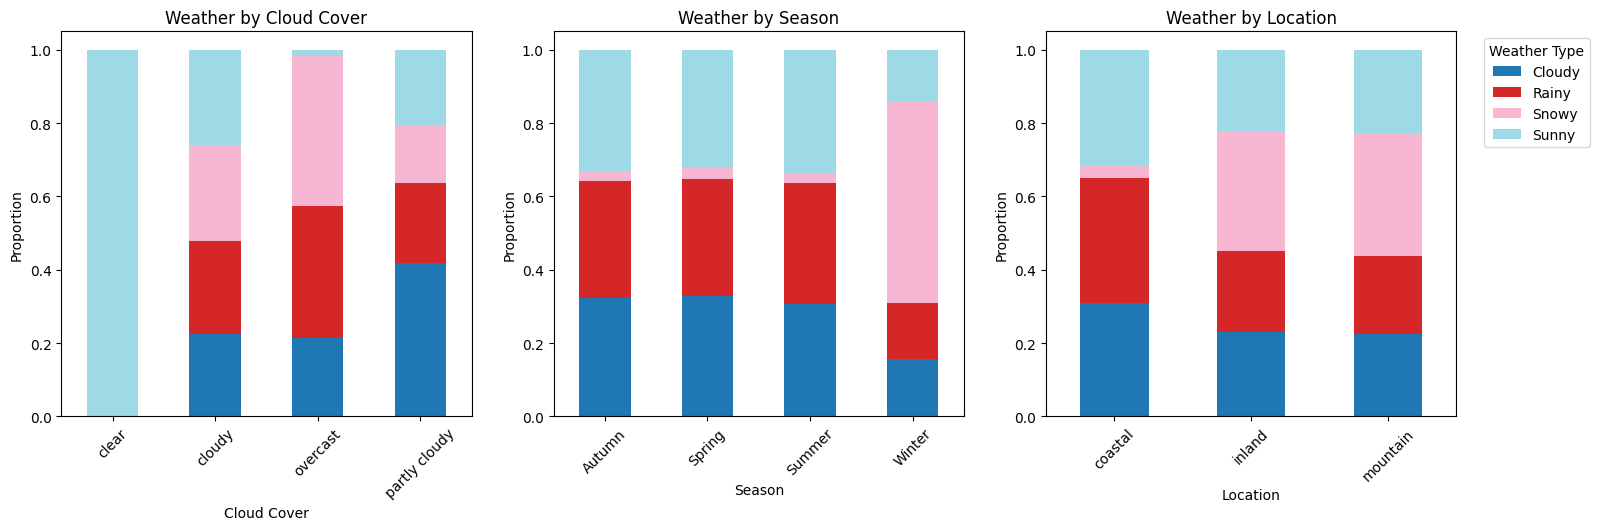

In [26]:
plt.figure(figsize=(18, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    pd.crosstab(df[col], df['Weather Type'], normalize='index').plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
    plt.title(f'Weather by {col}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    if i == len(categorical_cols) - 1:
        plt.legend(title='Weather Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()

Nhìn vào các stack bar plot của các biến categorical, em có một số nhận xét như sau:
- Biến `Cloud Cover`: == `clear` thì `Weather Type` == `Sunny`, dễ thấy điều này rất hiển nhiên bằng cách nhìn vào bar plot và cũng vì sự thật là trời không mây thì không thể mưa lẫn rơi tuyết, cũng không thể là `Cloudy`
- Biến `Season`: có điểm bất thường là thời tiết `Snowy` xuất hiện trong cả mùa hè lẫn mùa thu, em nghĩ khả năng cao đây là nhiễu. Đây là 1 feature tốt để phân biệt `Snowy` với các lớp khác dựa vào `Season` có là `Winter` hay không.
- Biến `Location`: đây cũng là 1 feature tốt để phân biệt `Snowy` với các lớp khác dựa vào `Location` có là `coastal` hay không.
- Hai giá trị `Season_Winter` và `Location_Coastal` có số lượng nhiều hơn hẳn và ít hơn hẳn so với các giá trị khác trong cùng 1 feature. Hai giá trị này có thể giúp cho việc phân loại class `Snowy` và class `Sunny` khi sử dụng mô hình `RandomForest` sau này (cũng dựa vào tri thức miền là Winter thường có Snowy và Coastal thường hay xảy ra Sunny)

Sau khi phân tích tất cả feature numerical lẫn categorical, em sẽ dùng kiểm định chi-square cho các biến categorical và kiểm định ANOVA cho các biến numerical để kiểm định mối quan hệ giữa các feature đó với biến target `Weather Type`.

In [27]:
from scipy.stats import chi2_contingency, f_oneway
df = pd.read_csv("6. Weather.csv")
# xử lý outlier, đưa về giá trị max có thể
df['Temperature'] = df['Temperature'].clip(upper=95)
df['Humidity'] = df['Humidity'].clip(upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(upper=100)
print("Chi-Square Test (Categorical):")
numerical_cols = ['Temperature','Humidity','Precipitation (%)','UV Index','Atmospheric Pressure','Wind Speed','Visibility (km)']
categorical_cols = ['Cloud Cover','Season','Location']
for col in categorical_cols:
    table = pd.crosstab(df[col], df['Weather Type'])
    chi2, p, *_ = chi2_contingency(table)
    print(f"{col}: p = {p}")

# ANOVA Test cho numerical
print("\nANOVA Test (Numerical):")
for col in numerical_cols:
    groups = [group[col].values for name, group in df.groupby('Weather Type')]
    stat, p = f_oneway(*groups)
    print(f"{col}: p = {p}")

Chi-Square Test (Categorical):
Cloud Cover: p = 0.0
Season: p = 0.0
Location: p = 1.0518112073147385e-263

ANOVA Test (Numerical):
Temperature: p = 0.0
Humidity: p = 0.0
Precipitation (%): p = 0.0
UV Index: p = 0.0
Atmospheric Pressure: p = 7.092866657179706e-207
Wind Speed: p = 0.0
Visibility (km): p = 0.0


Hai loại kiểm định ANOVA và Chi-square giả định `H_0` rằng 2 biến đang kiểm định độc lập với nhau. Với kết quả p-value ở trên rất nhỏ hơn so với 0.05, ta có thể bác bỏ giả thuyết độc lập và nhận xét: toàn bộ các feature đều liên quan có ý nghĩa thống kê đến biến target `Weather Type`. Vì vậy, em sẽ dùng toàn bộ feature để train mô hình.

#### **3. Train mô hình**
Em sẽ lựa chọn `Random Forest` cho dữ liệu này vì có các categorical feature, và cũng vì đây là một phương pháp ensemble nên có thể lấy mẫu, xử lý nhiễu. Em chia train-test stratify theo biến target `Weather Type` để đảm bảo phân bố nhãn giống giữa tập train, test. Đồng thời em cũng set seed = 42 để đảm bảo nhất quán giữa các lần chạy và kết quả reproducible. Các bước train mô hình sẽ là: 
- Đưa các outlier ngoài vùng cho phép về max.
- One hot encoding các feature categorical.
- Chia thành tập train - test. Không cần chia tập val để tune vì dữ liệu này có vẻ dễ.
- Train và đánh giá trên tập test

accuracy: 0.9096969696969697
f1: 0.9099843354136431


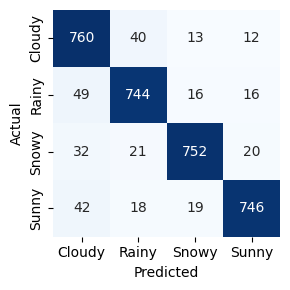

Class           Precision  Recall     F1-Score  
Cloudy          0.861      0.921      0.890     
Rainy           0.904      0.902      0.903     
Snowy           0.940      0.912      0.926     
Sunny           0.940      0.904      0.922     


In [28]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
df = df.join(encoded_df)
df = df.drop(categorical_cols, axis=1)
df['Temperature'] = df['Temperature'].clip(upper=95)
df['Humidity'] = df['Humidity'].clip(upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(upper=100)
X = df.drop(columns='Weather Type')
y = df['Weather Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred, average='macro')
confusion = confusion_matrix(y_test, Y_pred)
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')
labels = model.classes_  
plt.figure(figsize=(3, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

report_dict = classification_report(y_test, Y_pred, target_names=labels, output_dict=True)
per_class_report = {label: [f"{v['precision']:.3f}", f"{v['recall']:.3f}", f"{v['f1-score']:.3f}"] 
                    for label, v in report_dict.items() if label in labels}

print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
for label, scores in per_class_report.items():
    print(f"{label:<15} {scores[0]:<10} {scores[1]:<10} {scores[2]:<10}")

Nhìn vào kết quả đối xứng qua 2 đường chéo chính, ta thấy mô hình thường phân biệt sai hai lớp `Cloudy` vs `Rainy`: 2 giá trị 49 - 40 là tổng lớn nhất. `Cloudy` vs `Sunny`: 2 giá trị 42 - 12 là nhiều thứ hai. Kết quả này cũng cho thấy `Rainy` và `Cloudy` có Precision thấp nhất. Phía dưới là plot importance của các feature sử dụng cho model `Random Forest`

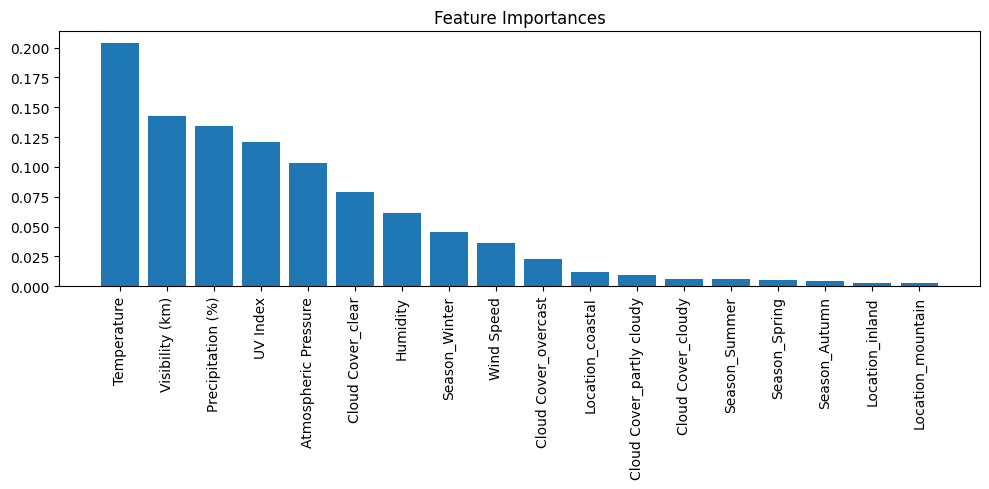

In [29]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.keys()
plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()

Với công thức tính importance của `RandomForest` tỷ lệ thuận theo chỉ số `Gini` càng cao càng tốt (các thuật toán tree-based trong `scikit-learn` chỉ hỗ trợ phân 2 nhánh, tức là sau khi phân thành 2 node thì số class trong mỗi node càng ít thì Gini càng cao, feature được sử dụng để phân nhánh càng 'important'), ta cũng có thể đoán được phần nào là feature quan trọng khi nhìn vào boxplot và stacked bar plot ở phần 2. Xét top 4 feature quan trọng nhất:
- `Temperature` và `UV Index`: box plot thể hiện phân bố giá trị 2 feature này của class `Snowy` khác biệt rõ rệt so với các class còn lại => chứng tỏ đây là 2 feature tốt cho việc phân loại `Snowy` với không `Snowy`, split cây trong `RandomForest`. `UV Index` của Sunny cũng cao hơn hẳn so với các biến còn lại
- `Precipitation`: class `Sunny` có khoảng giá trị tập trung bé hơn hẳn so với các class khác (độ rộng 2 ria của boxplot bé hơn các class khác). Nên đây cũng là 1 feature tốt phân biệt `Sunny` với không `Sunny`
- `Visibility`: nhìn vào box plot, ta dễ thấy có thể split thành 2 node - 1 bên chứa `Rainy` và `Snowy` do 2 class này có phân bố gần giống nhau, 1 bên chứa class còn lại => nên chỉ số Gini cũng cao và được coi là 1 feature tốt
Cũng có thể dễ thấy là các 

#### **4. Phân tích kết quả**
Để hiểu tại sao model lại phân biệt sai giữa các class, em đã nhìn vào boxplot phần 2 cũng như importance của các feature được plot ra và đưa ra một số nhận định về hai loại sai nhiều nhất như sau:
- **Phân biệt sai `Rainy` và `Cloudy`**: tuy 2 class này khác nhau rõ rệt giữa `Visibility` và `Precipitation`, nhưng chúng lại có phân bố các numerical feature khác rất giống nhau. Đặc biệt, 2 feature quan trọng `Temperature` - `UV Index` lại khá tương đồng giống nhau về mặt phân bố giá trị. 
- **Phân biệt sai `Sunny` và `Cloudy`**: 2 class này lại có phân bố khá giống nhau ngay ở feature có mức ảnh hưởng thứ hai là: `Visibility`

Vì vậy em sẽ đi kiểm định và nhìn sâu hơn vào phân bố các feature được đề cập giữa `Rainy` và `Cloudy`, `Sunny` và `Cloudy` trên tập train ở phần sau. 

In [30]:
df_train = X_train.copy()
df_train['Weather Type'] = y_train
df_test = X_test.copy()
df_test['Weather Type'] = y_test

#### **5. Kiểm định giả thuyết**
Em đang nghi ngờ phân bố của feature `Temperature` giữa 2 class `Rainy` và `Cloudy` khi nhìn vào boxplot. Để kiểm tra xem trung bình hai nhóm có khác biệt thật hay không, em sẽ dùng permutation test (theo hướng dẫn trong HW07). 
- Khi xét 2 phân phối có giống nhau hay không, ta thường nhìn vào các tham số thống kê như là: mean, variance. Em sẽ lấy mức ý nghĩa $\alpha$ = 0.05
- Permutation test là phương pháp kiểm định phi tham số: ta gộp giá trị của hai nhóm lại, rồi tráo (permute) nhãn nhiều lần để xây dựng phân phối ngẫu nhiên của hiệu số trung bình dưới giả thuyết không (`H_0`: hai nhóm có cùng phân phối).
- Giá trị p-value trong kiểm định này là xác suất để thu được (hoặc vượt) hiệu số trung bình quan sát được, giả sử `H_0` đúng. Nếu p-value nhỏ hơn alpha (ví dụ 0.05), tức là hiệu số thực tế hiếm xảy ra dưới giả thuyết `H_0`, ta bác bỏ `H_0`.
- Em chọn permutation test thay cho Z-test vì không cần giả định dữ liệu phải tuân theo phân phối chuẩn, cũng không cần biết trước phương sai từng nhóm. 


So sánh mean Rainy vs Cloudy trên [Train set]
Observed mean difference = -0.598, Permutation p-value = 0.4310

So sánh variance Rainy vs Cloudy trên [Train set]
Observed variance difference = 25.211, Permutation p-value = 0.2870

So sánh mean Rainy vs Cloudy trên [Test set]
Observed mean difference = -1.016, Permutation p-value = 0.1590

So sánh variance Rainy vs Cloudy trên [Test set]
Observed variance difference = -15.218, Permutation p-value = 0.4190


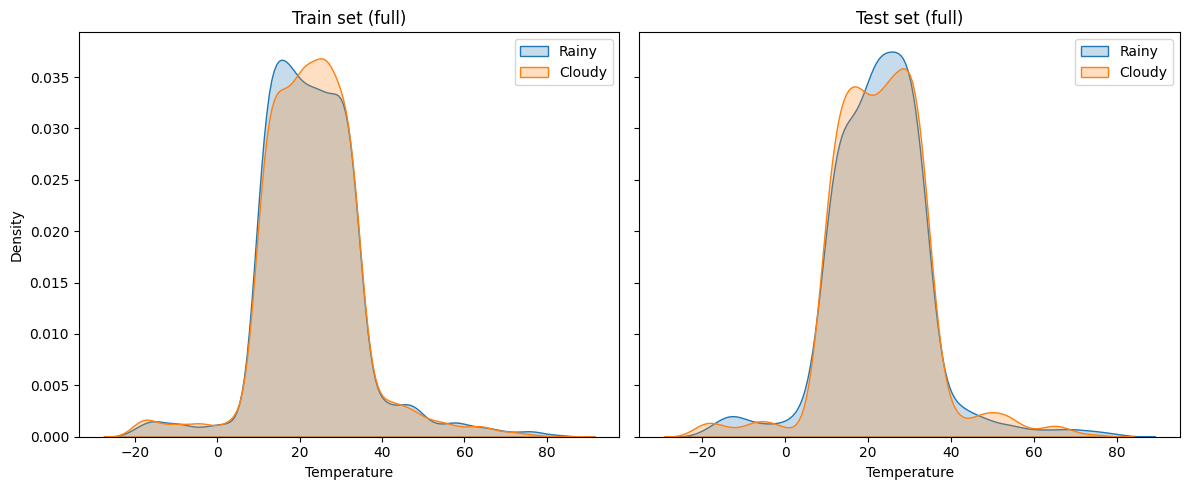

In [91]:
def permutation_test_mean(df, class1_name, class2_name, feature, name='Data'):
    n_iter=1000 
    sample_size=500
    class1_sample = df[df['Weather Type'] == class1_name][feature].sample(sample_size, replace=True)
    class2_sample = df[df['Weather Type'] == class2_name][feature].sample(sample_size, replace=True)
    obs_mean_diff = class1_sample.mean() - class2_sample.mean()
    obs_var_diff = class1_sample.var(ddof=1) - class2_sample.var(ddof=1)
    combined = np.concatenate([class1_sample.values, class2_sample.values])
    perm_mean_diffs = []
    perm_var_diffs = []
    for _ in range(n_iter):
        np.random.shuffle(combined)
        perm1 = combined[:sample_size]
        perm2 = combined[sample_size:]
        perm_mean_diffs.append(perm1.mean() - perm2.mean())
        perm_var_diffs.append(np.var(perm1, ddof=1) - np.var(perm2, ddof=1))

    perm_mean_diffs = np.array(perm_mean_diffs)
    perm_var_diffs = np.array(perm_var_diffs)
    p_value_mean = np.mean(np.abs(perm_mean_diffs) >= np.abs(obs_mean_diff))
    p_value_var = np.mean(np.abs(perm_var_diffs) >= np.abs(obs_var_diff))
    print(f"\nSo sánh mean {class1_name} vs {class2_name} trên [{name}]")
    print(f"Observed mean difference = {obs_mean_diff:.3f}, Permutation p-value = {p_value_mean:.4f}")
    print(f"\nSo sánh variance {class1_name} vs {class2_name} trên [{name}]")
    print(f"Observed variance difference = {obs_var_diff:.3f}, Permutation p-value = {p_value_var:.4f}")
    return class1_sample, class2_sample


def plot_kde(ax, class1_data, class2_data, class1_name, class2_name, title, feature):
    sns.kdeplot(class1_data, label=class1_name, fill=True, ax=ax)
    sns.kdeplot(class2_data, label=class2_name, fill=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.legend()

rainy_train_sample_temp, cloudy_train_sample_temp = permutation_test_mean(df_train, 'Rainy', 'Cloudy', 'Temperature', name='Train set')
rainy_test_sample, cloudy_test_sample   = permutation_test_mean(df_test,  'Rainy', 'Cloudy', 'Temperature', name='Test set')
rainy_train_all = df_train[df_train['Weather Type'] == 'Rainy']['Temperature']
cloudy_train_all = df_train[df_train['Weather Type'] == 'Cloudy']['Temperature']
rainy_test_all  = df_test[df_test['Weather Type'] == 'Rainy']['Temperature']
cloudy_test_all  = df_test[df_test['Weather Type'] == 'Cloudy']['Temperature']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_kde(axes[0], rainy_train_all,cloudy_train_all,'Rainy', 'Cloudy','Train set (full)','Temperature')
plot_kde(axes[1], rainy_test_all,cloudy_test_all,'Rainy','Cloudy','Test set (full)','Temperature')

plt.tight_layout()
plt.show()

- `H_011`: trung bình của `Temperature` giữa hai lớp Rainy và Cloudy không khác biệt.
- `H_012`: phương sai của `Temperature` giữa hai lớp Rainy và Cloudy không khác biệt. 

Với giá trị p-value > $\alpha$ = 0.05, ta không bác bỏ `H_011` lẫn `H_012`. Ta có thể thấy rõ là 2 class này gần như có phân bố `Temperature` gần như giống hệt nhau và chỉ khác nhau một chút ở đỉnh của histogram. Đây có thể là một phần nguyên do khiến `RandomForest` nhầm lẫn giữa 2 class này nhiều nhất khi feature `Temperature` có độ quan trọng cao nhất mà 2 class này lại có phân bố khá giống nhau ở feature này.


So sánh mean Rainy vs Cloudy trên [Train set]
Observed mean difference = -1.234, Permutation p-value = 0.0000

So sánh variance Rainy vs Cloudy trên [Train set]
Observed variance difference = -2.236, Permutation p-value = 0.1150

So sánh mean Rainy vs Cloudy trên [Test set]
Observed mean difference = -1.242, Permutation p-value = 0.0000

So sánh variance Rainy vs Cloudy trên [Test set]
Observed variance difference = -1.022, Permutation p-value = 0.4820


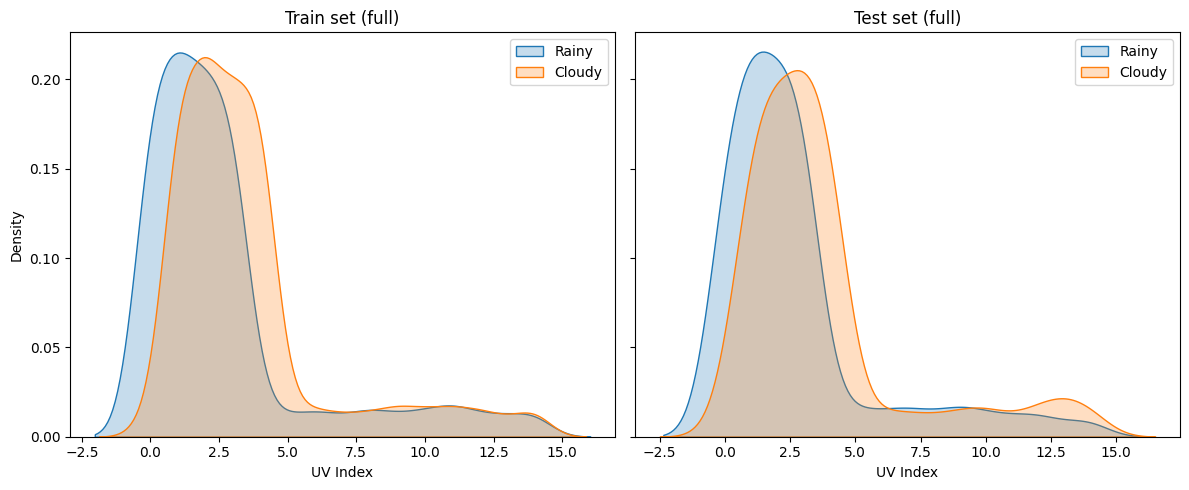

In [92]:
rainy_train_uv, cloudy_train_uv = permutation_test_mean(df_train, 'Rainy', 'Cloudy', 'UV Index', name='Train set')
rainy_test_uv, cloudy_test_uv = permutation_test_mean(df_test, 'Rainy', 'Cloudy', 'UV Index', name='Test set')

rainy_train_all = df_train[df_train['Weather Type'] == 'Rainy']['UV Index']
cloudy_train_all = df_train[df_train['Weather Type'] == 'Cloudy']['UV Index']
rainy_test_all  = df_test[df_test['Weather Type'] == 'Rainy']['UV Index']
cloudy_test_all  = df_test[df_test['Weather Type'] == 'Cloudy']['UV Index']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_kde(axes[0], rainy_train_all,cloudy_train_all,'Rainy', 'Cloudy','Train set (full)','UV Index')
plot_kde(axes[1], rainy_test_all,cloudy_test_all,'Rainy','Cloudy','Test set (full)','UV Index')

plt.tight_layout()
plt.show()

- `H_021`: trung bình của `UV Index` giữa hai lớp `Rainy` và `Cloudy` không khác biệt. 
- `H_022`: phương sai của `UV Index` giữa hai lớp `Rainy` và `Cloudy` không khác biệt. 

Với giá trị p-value < $\alpha$ = 0.05, ta bác bỏ giả thuyết `H_021` khi nhìn vào histogram trên ta cũng thấy là hai giá trị trung bình khác nhau. Tuy nhiên, ta không bác bỏ `H_022` với giá trị p > $\alpha$ = 0.05 tính được. Điều này cũng dễ thấy khi phân bố `UV Index` của hai class rất giống nhau về hình dáng, histogram của `Cloudy` gần như là histogram `UV Index` tịnh tiến lên một chút. 


So sánh mean Rainy vs Cloudy trên [Train set]
Observed mean difference = -3.649, Permutation p-value = 0.0000

So sánh variance Rainy vs Cloudy trên [Train set]
Observed variance difference = 1.243, Permutation p-value = 0.4390

So sánh mean Rainy vs Cloudy trên [Test set]
Observed mean difference = -3.070, Permutation p-value = 0.0000

So sánh variance Rainy vs Cloudy trên [Test set]
Observed variance difference = 3.754, Permutation p-value = 0.0120


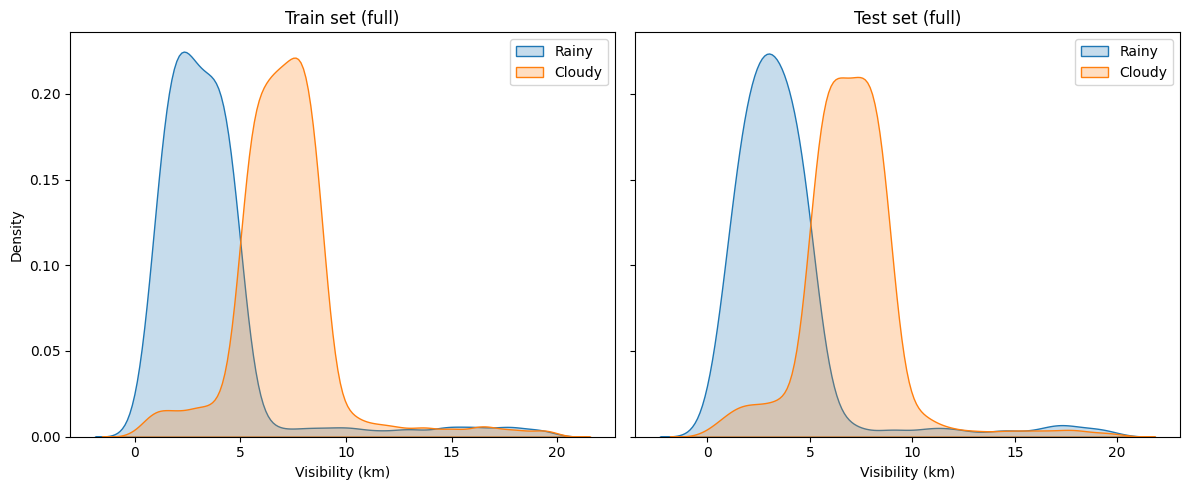

In [93]:
rainy_train_vis, cloudy_train_vis = permutation_test_mean(df_train, 'Rainy', 'Cloudy', 'Visibility (km)', name='Train set')
rainy_test_vis, cloudy_test_vis = permutation_test_mean(df_test, 'Rainy', 'Cloudy', 'Visibility (km)', name='Test set')
rainy_train_all = df_train[df_train['Weather Type'] == 'Rainy']['Visibility (km)']
cloudy_train_all = df_train[df_train['Weather Type'] == 'Cloudy']['Visibility (km)']
rainy_test_all  = df_test[df_test['Weather Type'] == 'Rainy']['Visibility (km)']
cloudy_test_all  = df_test[df_test['Weather Type'] == 'Cloudy']['Visibility (km)']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_kde(axes[0], rainy_train_all,cloudy_train_all,'Rainy', 'Cloudy','Train set (full)','Visibility (km)')
plot_kde(axes[1], rainy_test_all,cloudy_test_all,'Rainy','Cloudy','Test set (full)','Visibility (km)')

plt.tight_layout()
plt.show()

- `H_031`: trung bình của `Visibility` giữa hai lớp `Rainy` và `Cloudy` không khác biệt. 
- `H_032`: phương sai của `Visibility` giữa hai lớp `Rainy` và `Cloudy` không khác biệt. 

Ta cũng bác bỏ giả thuyết `H_031` với giá trị p-value tính được < $\alpha$ = 0.05. Nhận xét về biểu đồ này cũng giống như biểu đồ của `H_02` (histogram class này gần giống histogram class kia tịnh tiến theo trục Ox) nên mean feature này của 2 class không thể giống nhau được. Tuy nhiên, phương sai 2 class của trên tập train thì giống nhau nhưng trên tập test khác nhau 1 chút (giả thuyết `H_032` thì không bị bác bỏ trên tập train nhưng bác bỏ trên test với giá trị p-value tính được)


So sánh mean Sunny vs Cloudy trên [Train set]
Observed mean difference = 0.461, Permutation p-value = 0.0010

So sánh variance Sunny vs Cloudy trên [Train set]
Observed variance difference = 0.145, Permutation p-value = 0.8860

So sánh mean Sunny vs Cloudy trên [Test set]
Observed mean difference = 0.390, Permutation p-value = 0.0210

So sánh variance Sunny vs Cloudy trên [Test set]
Observed variance difference = 1.685, Permutation p-value = 0.1810


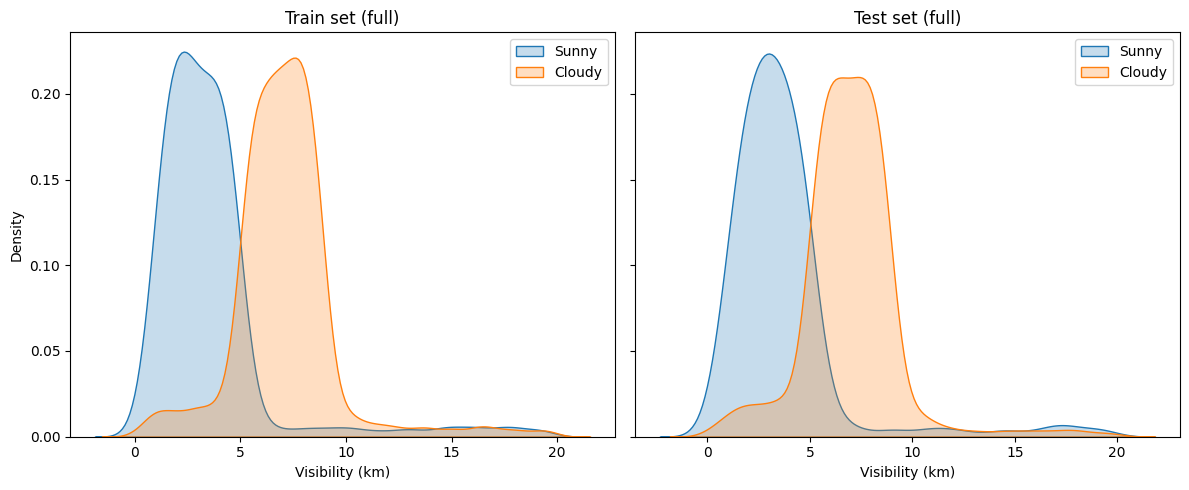

In [102]:
sunny_train_vis, cloudy_train_vis = permutation_test_mean(df_train, 'Sunny', 'Cloudy', 'Visibility (km)', name='Train set')
sunny_test_vis, cloudy_test_vis = permutation_test_mean(df_test, 'Sunny', 'Cloudy', 'Visibility (km)', name='Test set')
sunny_train_all = df_train[df_train['Weather Type'] == 'Sunny']['Visibility (km)']
cloudy_train_all = df_train[df_train['Weather Type'] == 'Cloudy']['Visibility (km)']
sunny_test_all  = df_test[df_test['Weather Type'] == 'Sunny']['Visibility (km)']
cloudy_test_all  = df_test[df_test['Weather Type'] == 'Cloudy']['Visibility (km)']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_kde(axes[0], rainy_train_all,cloudy_train_all,'Sunny', 'Cloudy','Train set (full)','Visibility (km)')
plot_kde(axes[1], rainy_test_all,cloudy_test_all,'Sunny','Cloudy','Test set (full)','Visibility (km)')

plt.tight_layout()
plt.show()

- `H_041`: trung bình của `Visibility` giữa hai lớp `Sunny` và `Cloudy` không khác biệt. 
- `H_042`: phương sai của `Visibility` giữa hai lớp `Sunny` và `Cloudy` không khác biệt. 

Ta cũng bác bỏ giả thuyết `H_041` trên với giá trị p-value tính được < 0.05, không bác bỏ `H_042`. Phân bố `Visibility` của 2 class này khá khác nhau nên có thể feature này không phải là feature gây ra confusion cho model `RandomForest`

#### **6. Thử nghiệm cải tiến mô hình bằng feature engineer**
Dựa vào biểu đồ feature importance ở phần 3, em quyết định thử tạo 1 feature mới là Dew Point (Điểm sương). [Điểm sương](https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%83m_s%C6%B0%C6%A1ng) là nhiệt độ hóa sương của một khối không khí, ở áp suất khí quyển cố định, mà ở đó thành phần hơi nước trong khối không khí ngưng đọng thành nước lỏng. 

[Công thức xấp xỉ](https://en.wikipedia.org/wiki/Dew_point) tính điểm sương:  $\text{Dew Point} \approx T - \frac{(100 - RH)}{5}$
- $T$ là nhiệt độ không khí (°C)  
- $RH$ (relative humidity) là độ ẩm tương đối (%) (là tỷ lệ % giữa lượng hơi nước thực tế trong không khí so với lượng hơi nước tối đa mà không khí có thể chứa ở cùng nhiệt độ.)  

Ví dụ:
- Với T = 25°C, RH = 100% thì Dew Point = 25°C tức là không khí bão hòa. 
- Với T = 25°C, RH = 50% thì Dew Point = 25 - (100 - 50)/5 = 15°C.

Nghĩa là với RH = 50%, nếu không khí từ 25°C được làm lạnh xuống dưới 15°C thì nước sẽ ngưng tụ. Nói cách khác, điểm sương là nhiệt độ mà độ ẩm tương đối của khối không khí đạt đến 100%. 

Dựa trên tính chất của điểm sương, ta có thể phân biệt các loại thời tiết như sau:​
- Rainy: khi Dew Point cao và gần bằng nhiệt độ không khí (RH → 100%), không khí đang ở trạng thái bão hòa hơi nước thì hơi nước ngưng tụ thành mưa dễ dàng hơn
- Cloudy: khi nhiệt độ giảm xuống gần Dew Point, đôi khi hơi nước không nhất thiết thành mưa mà ngưng tụ ở độ cao lớn hơn tạo thành mây.
- Sunny: Dew Point thấp cho thấy không khí khô, chứa rất ít hơi nước, nên ít khả năng hình thành mây và mưa, bầu trời quang đãng​
- Snowy: Nếu Dew Point dưới 0 °C (được gọi là “frost point”), hơi nước sẽ ngưng tụ trực tiếp thành băng tinh thể tuyết.

Em thêm feature này vào với hi vọng là có thể giúp cải thiện sự phân biệt sai giữa Rainy và Cloudy, cũng như phân biệt các class với nhau khi mà dew point cũng có sự khác nhau khá rõ giữa các class.

accuracy: 0.9142424242424242
f1: 0.9145377733751145


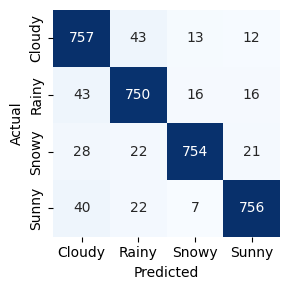

              precision    recall  f1-score   support

      Cloudy       0.87      0.92      0.89       825
       Rainy       0.90      0.91      0.90       825
       Snowy       0.95      0.91      0.93       825
       Sunny       0.94      0.92      0.93       825

    accuracy                           0.91      3300
   macro avg       0.92      0.91      0.91      3300
weighted avg       0.92      0.91      0.91      3300



In [35]:
df = pd.read_csv('6. Weather.csv')
df['Temperature'] = df['Temperature'].clip(upper=95)
df['Humidity'] = df['Humidity'].clip(upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(upper=100)
df['DewPoint'] = df['Temperature'] - (100 - df['Humidity']) / 5
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
df = df.join(encoded_df)
df = df.drop(categorical_cols, axis=1)
X = df.drop(columns='Weather Type')
y = df['Weather Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42) # chia train - test và random classifier đều set seed = 42 nên so sánh là chuẩn và kết quả reproducible
model_feat_eng = RandomForestClassifier(random_state=42)
model_feat_eng.fit(X_train, y_train)
Y_pred = model_feat_eng.predict(X_test)
accuracy = accuracy_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred, average='macro')
confusion = confusion_matrix(y_test, Y_pred)
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')
labels = model.classes_
plt.figure(figsize=(3, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
report_dict = classification_report(y_test, Y_pred, target_names=labels, output_dict=True)
print(classification_report(y_test, Y_pred, target_names=labels))


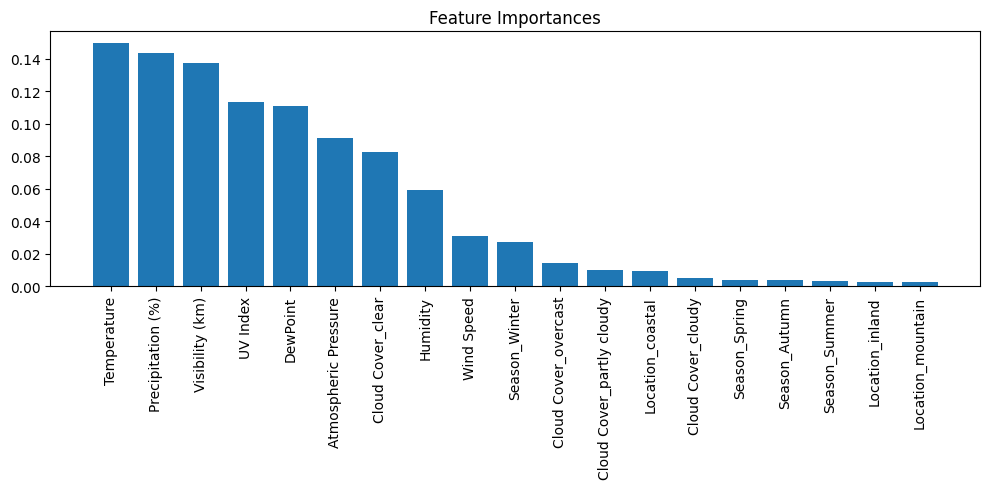

In [36]:
importances = model_feat_eng.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.keys()
plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()

**Kết luận:** 
- Cải tiến có vẻ không thành công lắm khi accuracy chỉ tăng được 0.4545% và f1-score chỉ tăng được 0.4553%. Có lẽ cũng do một phần `Temperature` của bộ dữ liệu này thu chưa chuẩn, có nhiều nhiễu nên `Dew Point` được tính theo công thức có dùng `Temperature` cũng bị ảnh hưởng. Nhưng feature `Dew Point` bổ sung vào cũng có importance khá cao.
- Ý tưởng ban đầu của em là dùng 1 mô hình phân lớp đơn giản sau đó dựa vào việc phân tích dữ liệu và chú ý vào các cặp class bị phân loại sai nhiều nhất. Em sẽ phân tích các feature của các cặp class đó để tiến hành bổ sung một rule-based model, áp lên kết quả của mô hình phân lớp phía trước để cải thiện các metric. Em đã thử ý tưởng đó và fail, có lẽ do suy luận của em chưa có cơ sở và em cũng chưa tìm được chỗ nào áp dụng. 

#### **7. Thử nghiệm cải tiến mô hình bằng phương pháp ensemble**

Ensemble accuracy: 0.9196969696969697
Ensemble f1-macro: 0.9199969402328876


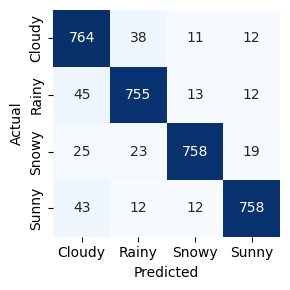

In [37]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
df = pd.read_csv("6. Weather.csv")
df['Temperature'] = df['Temperature'].clip(upper=95)
df['Humidity'] = df['Humidity'].clip(upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(upper=100)
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
df = df.join(encoded_df)
df = df.drop(categorical_cols, axis=1)
X = df.drop(columns='Weather Type')
y = df['Weather Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
Y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred, average='macro')
confusion = confusion_matrix(y_test, Y_pred)
print(f'Ensemble accuracy: {accuracy}')
print(f'Ensemble f1-macro: {f1}')
labels = ensemble.classes_
plt.figure(figsize=(3, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Kết luận:** Cải tiến cũng không quá đáng kể: 1% accuracy và 1% f1 score. Có thể là vì RF và GB đều là cây quyết định (decision trees, RF dùng phương pháp bagging còn GB dùng phương pháp boosting) nên dễ bị mắc lỗi giống nhau, ảnh hưởng bởi nhiễu giống nhau. 

(Ensemble chỉ mang lại lợi ích lớn khi các base-learner có sai số (errors) không tương quan (uncorrelated) với nhau. Nếu hai model đã “nhìn thấy” cùng những patterns/sai lệch, “kết hợp” cũng chỉ thêm phức tạp mà không giảm sai số đáng kể.)